In [1]:
import json
import random
import os

import cv2
import cyvlfeat
from matplotlib import pyplot as plt
import numpy as np
from pprint import pprint
import torch
import torchvision

from ipywidgets import *
from IPython.display import display

device = "cpu"

%matplotlib inline

# Function Definitions

In [30]:
def avg_blur_config(ksize):
    return {"ksize": (ksize, ksize)}

def median_blur_config(ksize):
    return {"ksize": (ksize, ksize)}

def bilateral_filter_config(d, sigmaColor, sigmaSpace):
    return {"d": d, "sigmaColor": sigmaColor, "sigmaSpace": sigmaSpace}

def gaussian_blur_config(ksize, sigmaX):
    return {"ksize": (ksize, ksize), "sigmaX": sigmaX}

def canny_config(threshold1, threshold2):
    return {"threshold1": threshold1, "threshold2": threshold2}

# ----------------------------------------------- #

def convert_grayscale(image, **kwargs): # **kwargs is ignored
    print("Converting to grayscale")
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def enhance_contrast(image, **kwargs): # **kwargs is ignored
    print("Enhancing contrast")
    return cv2.equalizeHist(image)

def apply_filter(image, kernel):
    return cv2.filter2D(image, ddepth=-1, kernel=kernel)

def apply_avg_blur(image, **kwargs):
    print("Applying average blur with args:", kwargs)
    return cv2.blur(image, **kwargs)

def apply_median_blur(image, **kwargs):
    print("Applying median blur with args:", kwargs)
    return cv2.medianBlur(img, ksize=(ksize,ksize))

def apply_bilateral_filter(image, **kwargs):
    print("Applying bilateral filter with args:", kwargs)
    return cv2.bilateralFilter(image, **kwargs)

def apply_gaussian_blur(image, **kwargs):
    print("Applying gaussian blur with args:", kwargs)
    return cv2.GaussianBlur(image, **kwargs)

def apply_canny(image, **kwargs):
    print("Applying canny with args:", kwargs)
    return cv2.Canny(image, **kwargs)

# laplacian = cv2.Laplacian(img, cv2.CV_64F)
# sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
# sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)


# ----------------------------------------------- #

def save_config(filename, config, selected):
    if not filename.endswith(".json"):
        filename += ".json"
        
    filtered_config = {k: config[k] for k in selected}
    
    with open(filename, "w") as file:
        json.dump(filtered_config, file, indent=4)
        
    print(filename, "is created.")
    
def load_config(json_content, config, config_ui):
    config.clear()
    config.update(json.loads(json_content))
    print("Configuration updated:")
    pprint(config)

def update_ui_with_state(): # TODO:
    # Update UI elements based on parameters
    #     for k in config:
    #         if config_ui[k]:
    #             config_ui[k].children[0].value = config[k]
    pass
    
def show_image(img, h=10, w=10):
    plt.figure(figsize=(w,h))
    plt.imshow(img)
    plt.show()

def show_image_pairs(left, right, h=15, w=15):
    f, ax = plt.subplots(1,2)
    f.set_figheight(h)
    f.set_figwidth(w)
    ax[0].imshow(left)
    ax[1].imshow(right)
    plt.show()

# Load Frames

In [3]:
# indices = list(range(1, 16))
# choice = str(random.choice(indices))
# print("Choice:", choice)
choice = str(13)

rgb_img_ext = choice + "_rgb.png"
depth_img_ext = choice + "_depth.png"
depth_arr_ext = choice + "_depth.npy"

folders = os.listdir("frames")
folders = list(map(lambda folder: os.path.join("frames", folder), folders))
triplets = []
for folder in folders:
    rgb_im_path = os.path.join(folder, rgb_img_ext)
    depth_im_path = os.path.join(folder, depth_img_ext)
    depth_arr_path = os.path.join(folder, depth_arr_ext)
    
    rgb_img = cv2.imread(rgb_im_path, cv2.IMREAD_COLOR)     # BGR image
    depth_img = cv2.imread(depth_im_path, cv2.IMREAD_COLOR) # BGR image
    depth_arr = np.load(depth_arr_path)
    triplets.append((rgb_img, depth_img, depth_arr))
    
print("Number of triplets:", len(triplets))

Number of triplets: 8


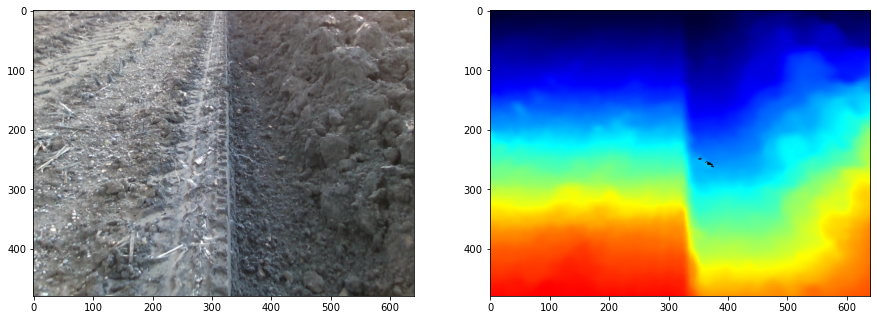

In [4]:
# indices = list(range(8))
# choice = str(random.choice(indices))
# print("Choice:", choice)
choice = 4

rgb_img, depth_img, depth_arr = triplets[choice]

show_image_pairs(rgb_img, depth_img)

# Configuration Parameters

In [20]:
# Parameters to tune
config = {
    "Grayscale": {},
    "Contrast": {},
    "Average Blur": {
        "ksize": 3
    },
    "Median Blur": {
        "ksize": 3
    },
    "Bilateral Filter": {
        "d":9, 
        "sigmaColor": 75, 
        "sigmaSpace": 75
    },
    "Gaussian Blur": {
        "ksize": 5, 
        "sigma": 3
    },
    "Canny Edges": {
        "threshold1": 25,
        "threshold2": 50
    },
    
}

# Binding names to actual methods:
preproc_funcs = {
    "Grayscale": convert_grayscale,
    "Contrast": enhance_contrast,
    "Average Blur": apply_avg_blur,
    "Median Blur": apply_median_blur,
    "Bilateral Filter": apply_bilateral_filter,
    "Gaussian Blur": apply_gaussian_blur,   
}

detect_funcs = {
    "Canny Edges": apply_canny,
}

# Defining UI elements for configurations
avg_blur_ui = interactive(avg_blur_config, ksize=(1,20))
median_blur_ui = interactive(median_blur_config, ksize=(1,20))
bilateral_filter_ui = interactive(bilateral_filter_config, d=(1,20), sigmaColor=(1,100), sigmaSpace=(1,100))
gaussian_blur_ui = interactive(gaussian_blur_config, ksize=(1,20), sigmaX=(1,20))
canny_ui = interactive(canny_config, threshold1=(0,100), threshold2=(0,100))

# Binding names to the configuration UI elements
preproc_ui = {
    "Grayscale": None,
    "Contrast": None,
    "Average Blur": avg_blur_ui,
    "Median Blur": median_blur_ui,
    "Bilateral Filter": bilateral_filter_ui,
    "Gaussian Blur": gaussian_blur_ui,   
}

detect_ui = {
    "Canny Edges": canny_ui,
}

# Preprocessing

In [6]:
style = {
    'description_width': 'initial'
}

preproccessing = SelectMultiple(
    options=preproc_ui.keys(),
    value=[],
    rows=len(preproc_ui.keys()),
    description='Preprocessing',
    disabled=False,
    style=style
)

detectors = SelectMultiple(
        options=detect_ui.keys(),
        value=[],
        rows=len(detect_ui.keys()),
        description='Detectors',
        disabled=False,
        style=style
)

selection = HBox([preproccessing, detectors])

display(selection)

In [21]:
selected = preproccessing.value + detectors.value
config_ui = {**preproc_ui, **detect_ui}
for k in selected:
    if config_ui[k]:
        print(k + ":")
        display(config_ui[k])

Gaussian Blur:


interactive(children=(IntSlider(value=10, description='ksize', max=20, min=1), IntSlider(value=10, description…

Canny Edges:


interactive(children=(IntSlider(value=50, description='threshold1'), IntSlider(value=50, description='threshol…

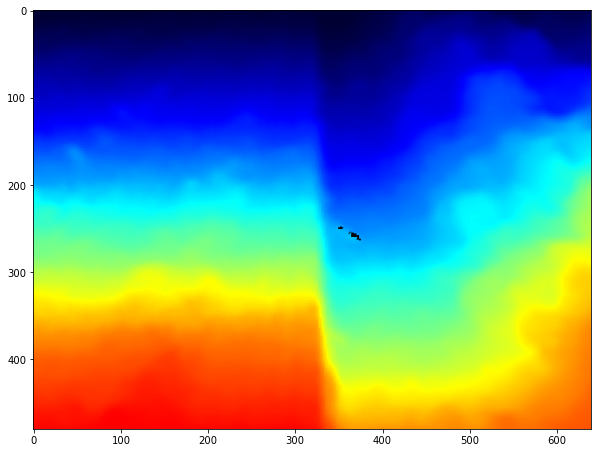

Applying gaussian blur with args: {'ksize': (5, 5), 'sigmaX': 10}


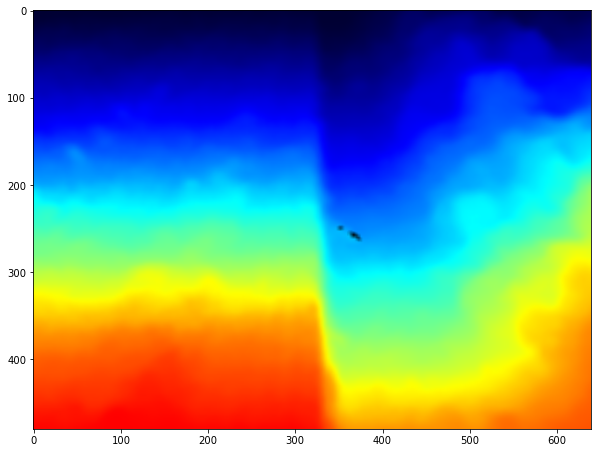

In [8]:
# Update parameters based on UI elements
for k in selected:
    if config_ui[k]:
        config[k] = config_ui[k].result

orig = depth_img
modified = orig.copy() # Modify the deep copy of the original image
show_image(orig)

for p in preproccessing.value:
    modified = preproc_funcs[p](modified, **config[p])
    show_image(modified)

# Feature Extraction

Applying canny with args: {'threshold1': 31, 'threshold2': 82}


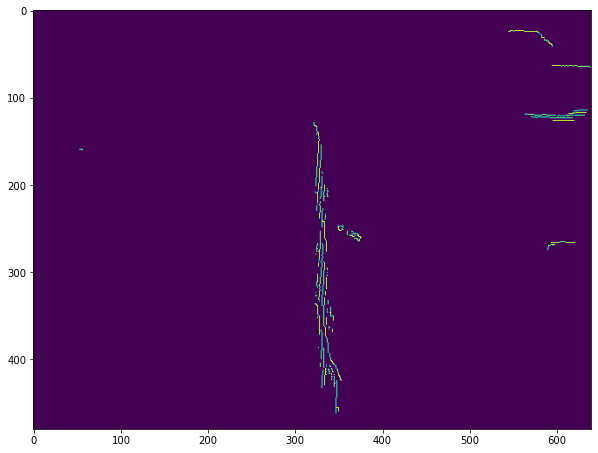

In [9]:
for d in detectors.value:
    modified = detect_funcs[d](modified, **config[d])
    show_image(modified)

# Store Current Settings

In [11]:
text = Text(
    value='filename.json',
    placeholder='Type something',
    description='Filename:',
    disabled=False
)


button = Button(
    description='Store',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
)

mini_form = HBox([text, button])

button.on_click(lambda _: save_config(text.value, config, selected))

display(mini_form)

settings.json is created.


# Load Settings

In [31]:
uploader_ui = FileUpload(
    accept='.json',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

uploader_ui.observe(lambda _: load_config(*uploader_ui.data, config, config_ui), names='_counter')

display(uploader_ui)

FileUpload(value={}, accept='.json', description='Upload')

Configuration updated:
{'Canny Edges': {'threshold1': 31, 'threshold2': 82},
 'Gaussian Blur': {'ksize': [5, 5], 'sigmaX': 10}}


 # Help

## cv2.cvtColor

In [ ]:
help(cv2.cvtColor)

## cv2.equalizeHist

In [ ]:
help(cv2.equalizeHist)

## cv2.filter2D

In [ ]:
help(cv2.filter2D)

## cv2.blur

In [ ]:
help(cv2.blur)

## cv2.medianBlur

In [ ]:
help(cv2.medianBlur)

## cv2.bilateralFilter

In [ ]:
help(cv2.bilateralFilter)

## cv2.GaussianBlur

In [ ]:
help(cv2.GaussianBlur)

## cv2.Sobel

In [ ]:
help(cv2.Sobel)

## cv2.Laplacian

In [ ]:
help(cv2.Laplacian)

## cv2.Canny

In [ ]:
help(cv2.Canny)